# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of Structure-Based Virtual Screening (SBVS), molecular descriptors and machine learning techniques for identifying active and inactive compounds given an SARS-CoV-2 assay. [Postera.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

## CONCLUSÃO
## Implementar run sge

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

0. [Imports](#imports)    


1. [Reading data](#reading_data)    
    1. [Activity data](#activity_data)    
    2. [Molecular docking and molecular descriptors](#molecular)    
    
    
2. [Machine learning](#machine_learning)     
    1. [Constructing the models](#constructing)     
    2. [Scoring metrics](#scoring_metrics)     
    3. [Running the models](#running)    
    
    
3. [Results](#results)    
    1. [Performace analysis](#performance_analysis)       
    2. [Finding the best subset](#finding)      
    3. [Reconstructing the top models](#reconstructing)    
    4. [ROC curves](#roc_curves)    
    5. [Regression plots](#regression)    
    
    
4. [Supplementary data](#supplementary)    
    1. [Correlations](#correlations)    
    2. [Comparing models and labels](#comparing)   
    3. [Docking scores and performance increment](#docking)    
    4. [Top descriptors](#top_descriptors)    

<a id='imports'></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

import multiprocessing
from functools import partial
import itertools
import time
import os
import subprocess

<a id='reading_data'></a>
## Reading data
<a id='activity_data'></a>
### Activity data

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69973
f_inhibition_at_50_uM,0.69973,1.00000


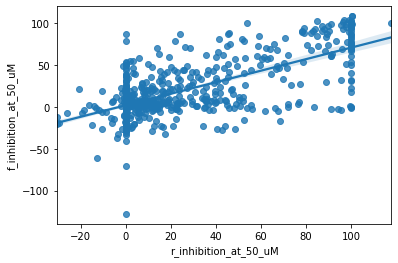

In [2]:
def write_data():
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open('activity_data.csv', 'wb') as f:
        f.write(r.content)
        
## Fetch activity data
#write_data()

# Read activity data
activity = pd.read_csv('activity_data.csv')

# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(x=activity['r_inhibition_at_50_uM'], y=activity['f_inhibition_at_50_uM'])
activity[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

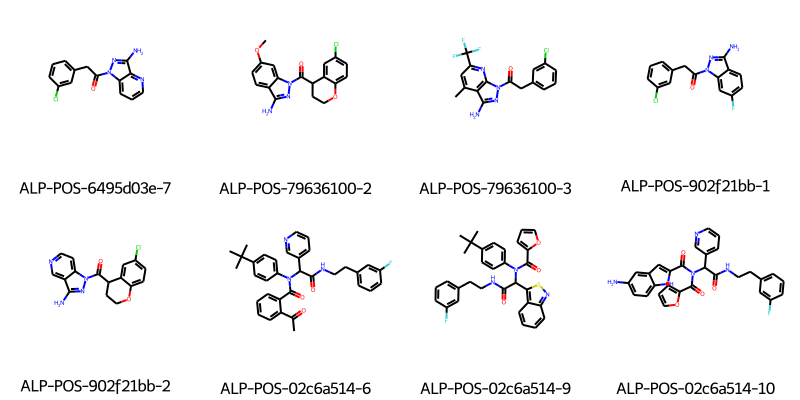

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

# Write into smiles
activity[['SMILES','CID']].to_csv('smiles.smi', sep=' ', index=False, header=None)
suppl = Chem.SmilesMolSupplier('smiles.smi')

# Compute 2D coordinates
ms = [x for x in suppl if x is not None]
d_list = []
for m in ms:
    d_list.append({'CID': m.GetProp('_Name'), 
                   'MolMR': Descriptors.MolMR(m), 
                   'NumRotatableBonds': Descriptors.NumRotatableBonds(m), 
                   'NumHAcceptors': Descriptors.NumHAcceptors(m), 
                   'NumHDonors': Descriptors.NumHDonors(m), 
                   'TPSA': Descriptors.LabuteASA(m), 
                   'LabuteASA': Descriptors.LabuteASA(m), 
                   'MolLogP': Descriptors.MolLogP(m)})
descriptors = pd.DataFrame(d_list)

# Draw
from rdkit.Chem import Draw
Draw.MolsToGridImage(ms[:8],
                     molsPerRow=4,
                     subImgSize=(200,200),
                     legends=[x.GetProp("_Name") for x in ms[:8]])    

<a id='molecular'></a>
### Molecular docking and molecular descriptors

In [4]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores and experimental data
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, activity[['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']])
del tmp

# Merge descriptors to "top"
data = pd.merge(descriptors, top)

#data.rename({'VABC Volume Descriptor': 'Volume', 
#             'Rotatable Bonds Count': 'RotatableBonds', 
#             'Topological Polar Surface Area': 'TPSA', 
#             'Molecular Weight': 'MolecularWeight'}, axis=1, inplace=True)
#data['Volume'] = data['Volume'].astype(float)

# Label actives and inactives in relation to "RapidFire"
data['r_active'] = data['r_inhibition_at_50_uM'] > 50
data['r_active'] = data['r_active'].astype(int) # 1 for active, 0 for inactive

# Label actives and inactives in relation to the fluorescence assay
data['f_active'] = data['f_inhibition_at_50_uM'] > 50
data['f_active'] = data['f_active'].astype(int) # 1 for active, 0 for inactive

data

,CID,MolMR,NumRotatableBonds,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,f_inhibition_at_50_uM,r_active,f_active
0,MAT-POS-02ae579f-1,142.9562,8,3,1,216.479769,216.479769,6.46320,-7.7,7.746907,-93.0745,7.544520,NaN,0.007703,0,0
1,MAT-POS-02ae579f-2,73.8221,2,3,3,115.581247,115.581247,1.51050,-7.2,6.285345,-80.1747,6.407342,NaN,2.287651,0,0
2,LOR-NOR-f9b26152-1,45.9122,1,3,1,78.672385,78.672385,0.96910,-5.5,4.929599,-59.7841,5.100658,7.794489,3.016446,0,0
3,LON-WEI-2e27a2e5-2,146.2802,8,4,1,222.124736,222.124736,5.66020,-7.3,7.575922,-97.6586,7.776974,NaN,-6.337255,0,0
4,MAT-POS-af71705c-1,86.0674,2,4,2,125.972082,125.972082,2.57750,-6.2,6.609277,-54.8444,6.834465,0.000000,-0.727192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,DAR-DIA-23aa0b97-15,66.1254,2,3,2,102.857248,102.857248,2.77400,-6.2,5.479310,-62.0836,5.861192,-0.075000,16.821870,0,0
939,DAR-DIA-23aa0b97-17,65.5227,3,4,1,104.126584,104.126584,1.52948,-6.5,6.595699,-74.1667,7.054006,12.695000,21.805805,0,0
940,DAR-DIA-23aa0b97-19,85.2337,3,3,1,127.588600,127.588600,3.28768,-6.6,6.733870,-79.4982,6.852397,85.160000,73.019885,1,1
941,DAR-DIA-23aa0b97-20,80.5187,3,2,1,116.831078,116.831078,3.41600,-7.0,6.307346,-77.3610,6.383954,62.475000,57.793870,1,1


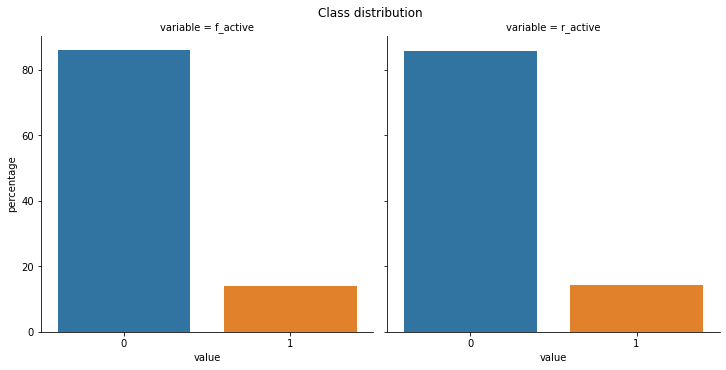

In [5]:
# Descriptors
descriptor_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']

train_set = descriptor_list + docking_list
data.dropna(subset=train_set, inplace=True)

tmp = pd.melt(data, id_vars=['CID'], value_vars=['r_active','f_active'])
tmp2 = (tmp.groupby(['variable'])['value'].value_counts(
    normalize=True).rename('percentage').mul(100).reset_index().sort_values('value'))
g = sns.catplot(data=tmp2, kind='bar', x='value', y='percentage', col='variable')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Class distribution')

del tmp, tmp2

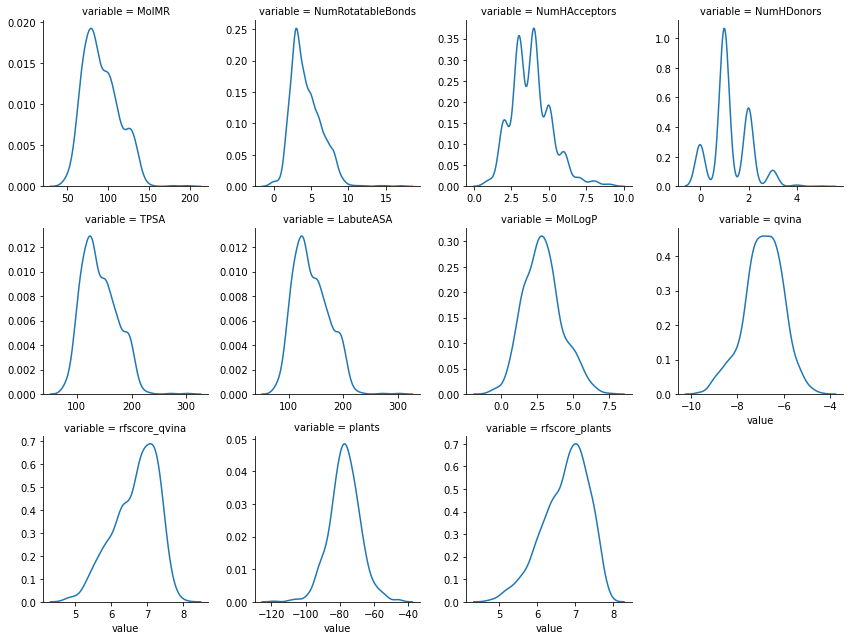

In [6]:
tmp = pd.melt(data, id_vars=['CID'], value_vars=train_set)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.kdeplot, 'value')

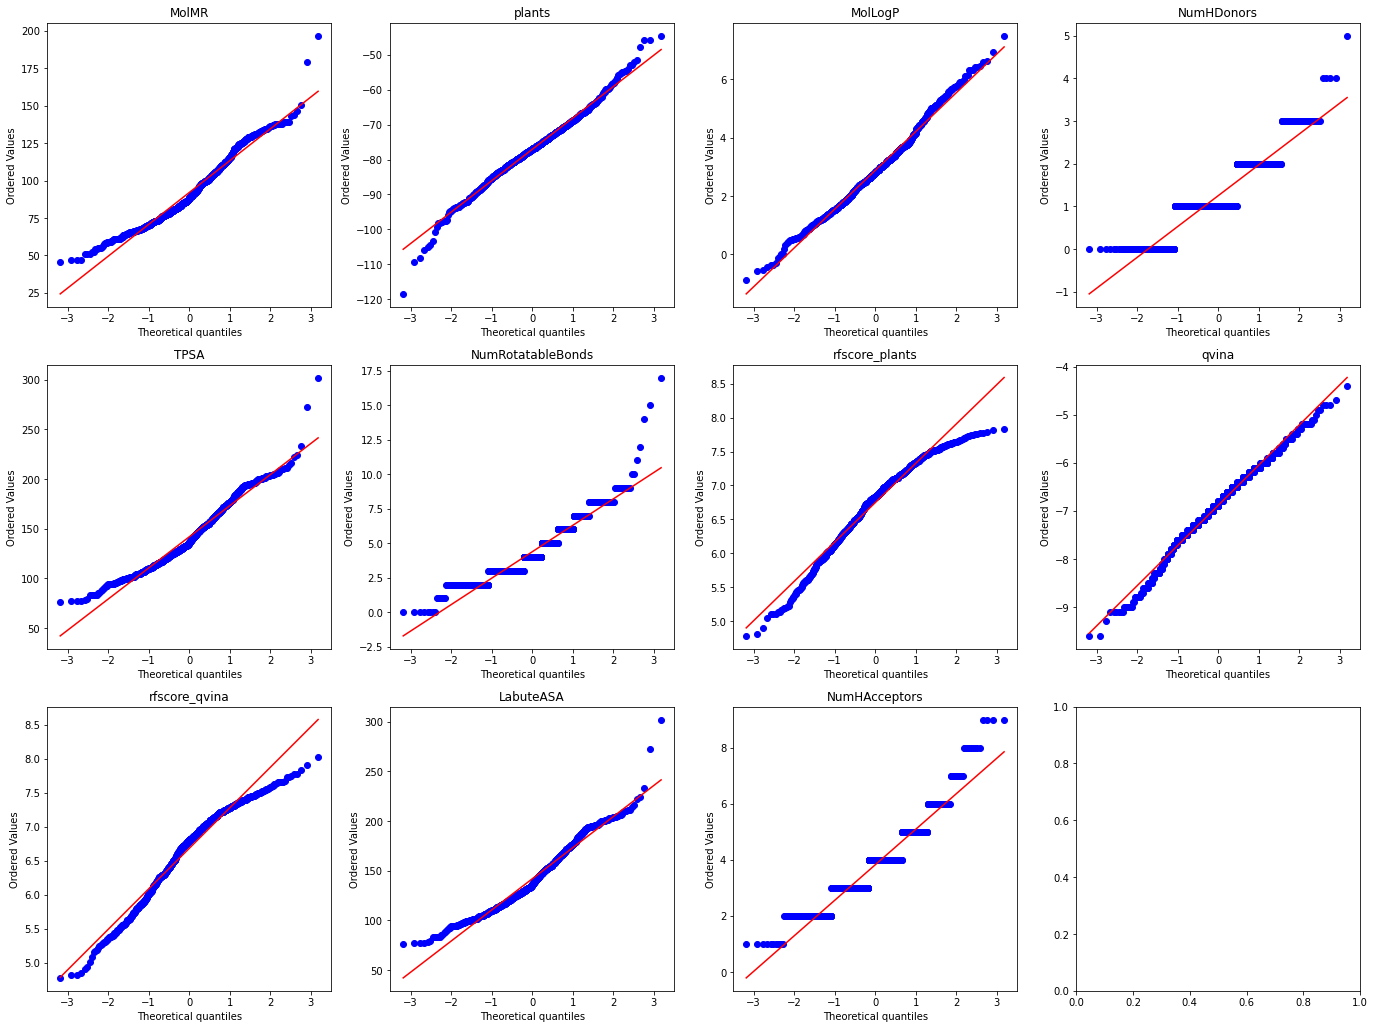

In [7]:
def qq_plot(X):
    from scipy.stats import probplot

    ncol = 4
    nrow = int(np.ceil(len(X.columns) / ncol))
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 4.8, nrow * 4.8))
    for i, x in enumerate(X.columns):
        probplot(data[x], dist='norm', plot=ax[i%nrow, i%ncol])
        ax[i%nrow, i%ncol].set_title(x)

    fig.tight_layout()
    plt.show()

qq_plot(data[train_set])

The data is approximately normaly distributed, and can be standardized. However, some descriptors present skewness and the QQ-Plot shows the outermost data has greater variance, which could indicate heteroskedacity (non-constant variance). 

<a id='machine_learning'></a>
## Machine learning
<a id='constructing'></a>
### Constructing the models

In [8]:
def get_combinations(min_len, list1, *args):
    # Get all subsets of a "main" list and N other lists
    combinations = []
    for sublist in args:
        list2 = list1 + sublist
        combinations += list(itertools.chain.from_iterable(
            itertools.combinations(list2, r) for r in range(min_len, len(list2)+1)))

    # Remove duplicates and return list
    return list(dict.fromkeys(combinations))

In [9]:
class myClass:
    @staticmethod
    def get_model_by_name(model_name):
        if model_name == 'LogisticRegression':
            model = LogisticRegression(solver='liblinear', random_state=13)
        elif model_name == 'LinearSVC':
            model = CalibratedClassifierCV(LinearSVC(dual=False, random_state=13))
        elif model_name == 'RandomForestClassifier':
            model = RandomForestClassifier(n_estimators=10, random_state=13)
        elif model_name == 'KNeighborsClassifier':
            model = KNeighborsClassifier(n_neighbors=5)
        elif model_name == 'XGBClassifier':
            model = XGBClassifier(objective='reg:logistic', random_state=13)
        elif model_name == 'DecisionTreeClassifier':
            model = DecisionTreeClassifier(random_state=13)
        elif model_name == 'LinearDiscriminantAnalysis':
            model = LinearDiscriminantAnalysis(solver='svd')
        else:
            model = None
        return model
    
    
    
    
    @staticmethod
    def get_scores(X, y, subset, train_set, scaler, random_state, activity_label, model):
        # Rebalance data with SMOTE and cross validate model
        pipe = make_pipeline(SMOTE(random_state=42), scaler, model)

        scoring_metrics = ['accuracy','precision','recall','f1','f2','g_mean','roc_auc']
        metrics = {key: [] for key in scoring_metrics}

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
        for train_index, test_index in skf.split(X, y): 
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
            model_fitted = pipe.fit(X_train, y_train)
            y_pred = model_fitted.predict(X_test)

            metrics['accuracy'].append(accuracy_score(y_test, y_pred)) # test_accuracy
            metrics['precision'].append(precision_score(y_test, y_pred)) # test_precision
            metrics['recall'].append(recall_score(y_test, y_pred)) # test_recall
            metrics['f1'].append(f1_score(y_test, y_pred)) # test_f1
            metrics['f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
            metrics['g_mean'].append(geometric_mean_score(y_test, y_pred)) # test_g_mean
            metrics['roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc

        # Mean of the KFold scores
        scores = [np.mean(value) for value in metrics.values()]
        scores.append(activity_label)
        scores.append(str(model).split('(')[0])
        scores.append(random_state)

        # Add binary list of the descriptors
        scores.extend([i in subset for i in train_set])
        return scores
    
    
    
    
    @staticmethod
    def run_models(data, scaler, seed_list, train_set, combinations, columns):
        ncpu = multiprocessing.cpu_count()
        # DataFrame for all models' scores
        scores_data = pd.DataFrame()
        model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                         RandomForestClassifier(n_estimators=10, random_state=13), 
                         KNeighborsClassifier(n_neighbors=5), 
                         LinearSVC(dual=False, random_state=13), 
                         XGBClassifier(objective='reg:logistic', random_state=13), 
                         DecisionTreeClassifier(random_state=13), 
                         LinearDiscriminantAnalysis(solver='svd')]
        for random_state in seed_list:
            for activity_label in ['r_active','f_active']:
                # Drop NaN activity and descriptor values
                new_data = data.dropna(subset=[activity_label])

                # Loop through all subset combinations (2, N)
                for subset in combinations:
                    subset = list(subset)

                    y = new_data[activity_label]
                    X = new_data[subset]

                    #X_train, X_test, y_train, y_test = train_test_split(
                    #    X, y, test_size=0.25, random_state=random_state)

                    # List of tuples for pool.map()
                    args = []
                    for model in model_list:
                        args.append((activity_label, model))

                    with multiprocessing.Pool(processes=ncpu) as pool:
                        scores = pool.starmap(partial(myClass.get_scores, X, y, subset, train_set, 
                                                      scaler, random_state), args)

                    # Append scores to all scores
                    scores = pd.DataFrame(scores, columns=columns+train_set)
                    scores_data = scores_data.append(scores)
        return scores_data
    
    
    
    
    @staticmethod
    def write_job(job_id, read_path, write_dir, subset, train_set, 
              scaler, random_state, activity_label, model, columns):
        if not os.path.isdir(f'{write_dir}/{job_id}'):
            os.mkdir(f'{write_dir}/{job_id}')

        with open(f'{write_dir}/{job_id}/run.py', 'w+') as file:
            file.write(f'''import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

subset = {subset}
train_set = {train_set}
scaler = {scaler}
random_state = {random_state}
activity_label = '{activity_label}'
model = {model}
columns = {columns}
data = pd.read_csv('{read_path}')
new_data = data.dropna(subset=[activity_label])
y = new_data[activity_label]
X = new_data[subset]

pipe = make_pipeline(SMOTE(random_state=42), scaler, model)
scoring_metrics = ['accuracy','precision','recall','f1','f2','g_mean','roc_auc']
metrics = {{key: [] for key in scoring_metrics}}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_fitted = pipe.fit(X_train, y_train)
    y_pred = model_fitted.predict(X_test)

    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))
    metrics['f2'].append(fbeta_score(y_test, y_pred, beta=2))
    metrics['g_mean'].append(geometric_mean_score(y_test, y_pred))
    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred))

scores = [np.mean(value) for value in metrics.values()]
scores.append(activity_label)
scores.append(str(model).split('(')[0])
scores.append(random_state)
scores.extend([i in subset for i in train_set])
df = pd.DataFrame([scores], columns=columns+train_set)
df.to_csv('{write_dir}/{job_id}/score.csv', index=False)
''')
        with open(f'{write_dir}/{job_id}/job.sh', 'w+') as file:
            file.write(f'''#!/bin/bash
#$ -N {job_id}
#$ -cwd
#$ -j y
#$ -S /bin/bash

conda activate rdkit
python {write_dir}/{job_id}/run.py
''')
        return
    
    
    
    
    @staticmethod
    def write_models(read_path, write_dir, scaler, seed_list, train_set, combinations, columns):
        if not os.path.isdir(write_dir):
            os.mkdir(write_dir)

        model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                         RandomForestClassifier(n_estimators=10, random_state=13), 
                         KNeighborsClassifier(n_neighbors=5), 
                         LinearSVC(dual=False, random_state=13), 
                         XGBClassifier(objective='reg:logistic', random_state=13), 
                         DecisionTreeClassifier(random_state=13), 
                         LinearDiscriminantAnalysis(solver='svd')]

        count = 0
        for random_state in seed_list:
            for activity_label in ['r_active','f_active']:
                # Drop NaN activity and descriptor values
                new_data = data.dropna(subset=[activity_label])

                # Loop through all subset combinations (2, N)
                for subset in combinations:
                    subset = list(subset)

                    for model in model_list:
                        myClass.write_job(count, read_path, write_dir, subset, train_set, 
                                  scaler, random_state, activity_label, model, columns)
                        count+=1
        return
    
    
    
    
    @staticmethod
    def submit_jobs(write_dir):
        for entry in os.scandir(write_dir):
            try:
                subprocess.run(f'qsub -q all.q@compute-1* {entry.path}/job.sh', 
                              stdout=subprocess.PIPE, stderr=subprocess.STDOUT, shell=True)
            except FileNotFoundError as e:
                print(f'File not found: {entry.path}')
            except OSError as e:
                print(f'OS Error: {e}')
            except RuntimeError as e:
                print(f'Runtime error: {e}')

<a id='scoring_metrics'></a>
### Scoring metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [10]:
# Get combinations of the molecule descriptors /
#                         molecule descriptors + "qvina" and/or "rfscore_qvina" /
#                         molecule descriptors + "plants" and/or "rfscore_plants"
combinations = get_combinations(2, descriptor_list, 
                                ['qvina','rfscore_qvina'], 
                                ['plants','rfscore_plants'])
# Test metrics
scoring_metrics = ['accuracy','precision','recall','f1','f2','g_mean','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]

columns = [*test_metrics, 'activity_label', 'model', 'random_state']

scaler = StandardScaler()
# List of random states
seed_list = [27]

<a id='running'></a>
### Running the models

In [11]:
run = 0

if run == 1:
    t0 = time.time()
    # Run all!
    scores_data = myClass.run_models(data, scaler, seed_list, train_set, combinations, columns)
    scores_data[train_set] = scores_data[train_set].astype(int)
    scores_data.to_csv('scores_data.csv', index=False)
    t1 = time.time()
    print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))
    
elif run == 2:
    read_path = 'data.csv'
    data.to_csv(read_path, index=False)
    write_dir = 'models'
    myClass.write_models(read_path, write_dir, scaler, seed_list, train_set, combinations, columns)
    myClass.submit_jobs(write_dir)

<a id='results'></a>
## Results
<a id='performance_analysis'></a>
### Performance analysis

In [12]:
# Read test scores and sort values
scores_data = pd.read_csv('scores_data.csv')
columns = scores_data.columns

selected = ['test_f2', 'test_g_mean', 'test_roc_auc']
#scores_data[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.groupby('model').head(1)

,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_g_mean,test_roc_auc,activity_label,model,random_state,...,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
6062,0.732771,0.297168,0.625282,0.402790,0.512073,0.685038,0.688106,r_active,LogisticRegression,27,...,1,1,1,1,1,0,0,1,0,0.628406
6117,0.718967,0.288764,0.639936,0.397215,0.513691,0.684081,0.686139,r_active,LinearDiscriminantAnalysis,27,...,1,1,1,1,1,0,0,1,1,0.627970
12259,0.743353,0.297679,0.610817,0.399305,0.503360,0.683133,0.687810,f_active,KNeighborsClassifier,27,...,1,1,1,1,1,0,0,0,1,0.624768
1004,0.713676,0.281405,0.632528,0.389223,0.505785,0.677972,0.679957,r_active,LinearSVC,27,...,1,1,0,0,1,0,0,0,0,0.621238
68,0.615030,0.228151,0.698712,0.343632,0.493996,0.647184,0.649852,r_active,DecisionTreeClassifier,27,...,0,1,0,0,0,0,0,0,0,0.597011
67,0.612907,0.227170,0.698712,0.342463,0.492968,0.645746,0.648612,r_active,XGBClassifier,27,...,0,1,0,0,0,0,0,0,0,0.595776
64,0.590614,0.218945,0.706119,0.333580,0.487340,0.634134,0.638685,r_active,RandomForestClassifier,27,...,0,1,0,0,0,0,0,0,0,0.586720


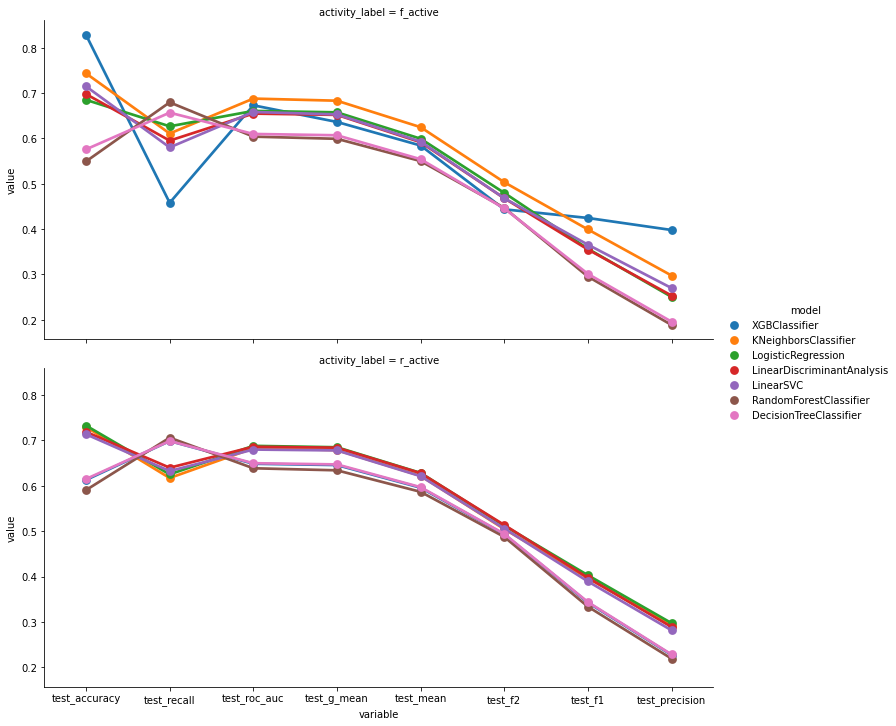

In [13]:
top = pd.melt(scores_data.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*train_set], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2)
plt.savefig('test_performance.png', dpi=216)

<a id='finding'></a>
### Finding the best subset

In [14]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}

activity_label = scores_data.iloc[0]['activity_label']
for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    best_subset[row['model']] = [descriptor for descriptor in train_set if row[descriptor]]

<a id='reconstructing'></a>
### Reconstructing the top models

In [15]:
# Probabilities for the top models
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# List of scores for the top models
scores_list = []
new_data = data.dropna(subset=train_set)

test_metrics = selected
train_metrics = [i.replace('test', 'train') for i in selected]
scoring_metrics = test_metrics + train_metrics

count = 0
for key, value in best_subset.items():
    model_name = key
    subset = value
    
    y = new_data[activity_label]
    X = new_data[subset]
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
        
    scaler = StandardScaler()
    pipe = make_pipeline(SMOTE(random_state=42), scaler, myClass.get_model_by_name(model_name))
        
    metrics = {key: [] for key in scoring_metrics}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        
        y_pred = model_fitted.predict(X_test)
        metrics['test_f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
        metrics['test_g_mean'].append(geometric_mean_score(y_test, y_pred)) # test_g_mean
        metrics['test_roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc
        
        y_pred = model_fitted.predict(X_train)
        metrics['train_f2'].append(fbeta_score(y_train, y_pred, beta=2)) # train_f2
        metrics['train_g_mean'].append(geometric_mean_score(y_train, y_pred)) # train_g_mean
        metrics['train_roc_auc'].append(roc_auc_score(y_train, y_pred)) # train_roc_auc
    
    # Mean of the KFold scores
    scores = [np.mean(value) for value in metrics.values()]

    #model_fitted = model.fit(X_train, y_train)
    #scores = get_train_test_scores(X_train, X_test, y_train, y_test, model_fitted)
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index
    count+=1

columns = ['model', *scoring_metrics]
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics].mean(axis=1)

<a id='roc_curves'></a>
### ROC curves

,model,test_f2,test_g_mean,test_roc_auc,train_f2,train_g_mean,train_roc_auc,test_mean,train_mean
0,LogisticRegression,0.512073,0.685038,0.688106,0.506646,0.682216,0.687207,0.628406,0.625356
1,LinearDiscriminantAnalysis,0.513691,0.684081,0.686139,0.501701,0.676547,0.680007,0.627970,0.619419
2,KNeighborsClassifier,0.504601,0.678753,0.682841,0.695567,0.819208,0.819377,0.622065,0.778051
3,LinearSVC,0.479815,0.659702,0.664711,0.490485,0.668740,0.673287,0.601409,0.610837
4,DecisionTreeClassifier,0.493996,0.647184,0.649852,0.538817,0.679304,0.685222,0.597011,0.634448
5,XGBClassifier,0.492968,0.645746,0.648612,0.535768,0.676657,0.682461,0.595776,0.631629
6,RandomForestClassifier,0.487340,0.634134,0.638685,0.541459,0.673830,0.684439,0.586720,0.633243


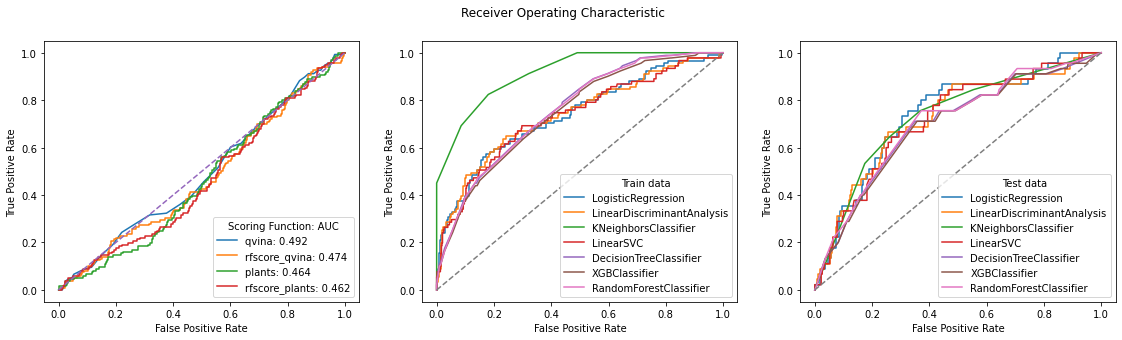

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')

plt.suptitle('Receiver Operating Characteristic')
plt.savefig('test_roc_curve.png', dpi=216)

top_scores

<a id='regression'></a>
### Regression plots

In [17]:
test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']], tmp, on=['CID'])

del tmp

Spearman R: 0.24860611649737133


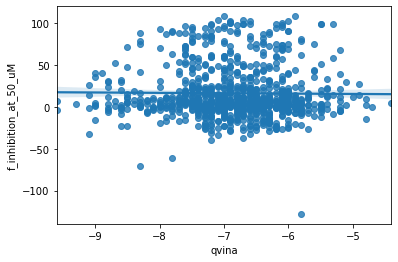

In [18]:
from scipy.stats import spearmanr

tmp = data.dropna(subset=['qvina', 'f_inhibition_at_50_uM'])
print(f"Spearman R: {spearmanr(tmp['qvina'], tmp['f_inhibition_at_50_uM'])[1]}")
del tmp

sns.regplot(data=data, x='qvina', y='f_inhibition_at_50_uM', )
plt.savefig('regplot_qvina.png', dpi=216)

Text(0.5, 0.98, 'Regression plots for the test set')

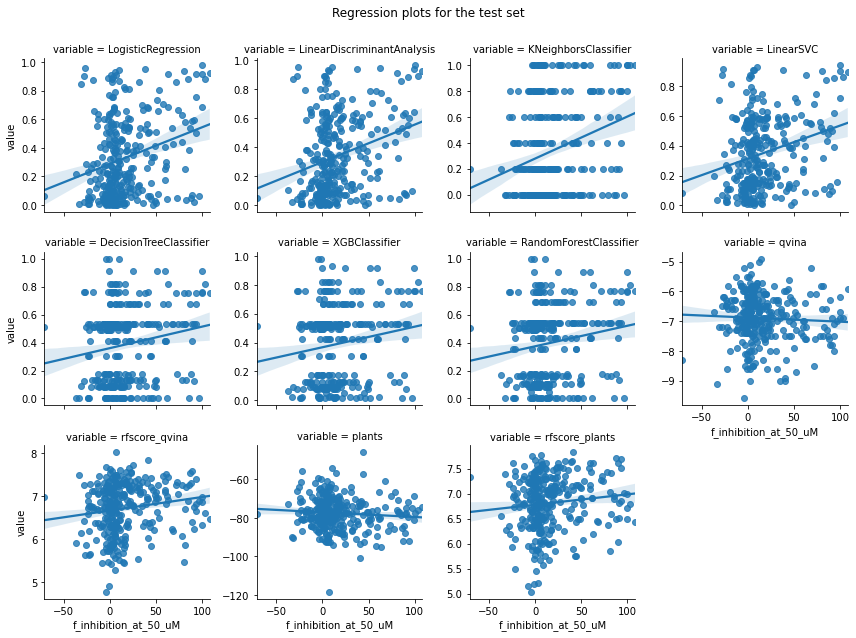

In [19]:
g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'f_inhibition_at_50_uM', 'value')

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Regression plots for the test set')

<a id='supplementary'></a>
## Supplementary data
<a id='correlations'></a>
### Correlations

In [20]:
# Pearson correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='pearson')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.717348
f_inhibition_at_50_uM,0.717348,1.000000
DecisionTreeClassifier,0.257734,0.154808
KNeighborsClassifier,0.397889,0.267764
LinearDiscriminantAnalysis,0.333662,0.259300
LinearSVC,0.307294,0.242194
LogisticRegression,0.340860,0.254688
RandomForestClassifier,0.261360,0.155327
XGBClassifier,0.256238,0.155156


In [21]:
# Spearman correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='spearman')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.572844
f_inhibition_at_50_uM,0.572844,1.000000
DecisionTreeClassifier,0.215964,0.151280
KNeighborsClassifier,0.321190,0.214125
LinearDiscriminantAnalysis,0.285089,0.239928
LinearSVC,0.267845,0.222943
LogisticRegression,0.291614,0.228790
RandomForestClassifier,0.208528,0.147613
XGBClassifier,0.222022,0.153751


<a id='comparing'></a>
### Comparing models and labels

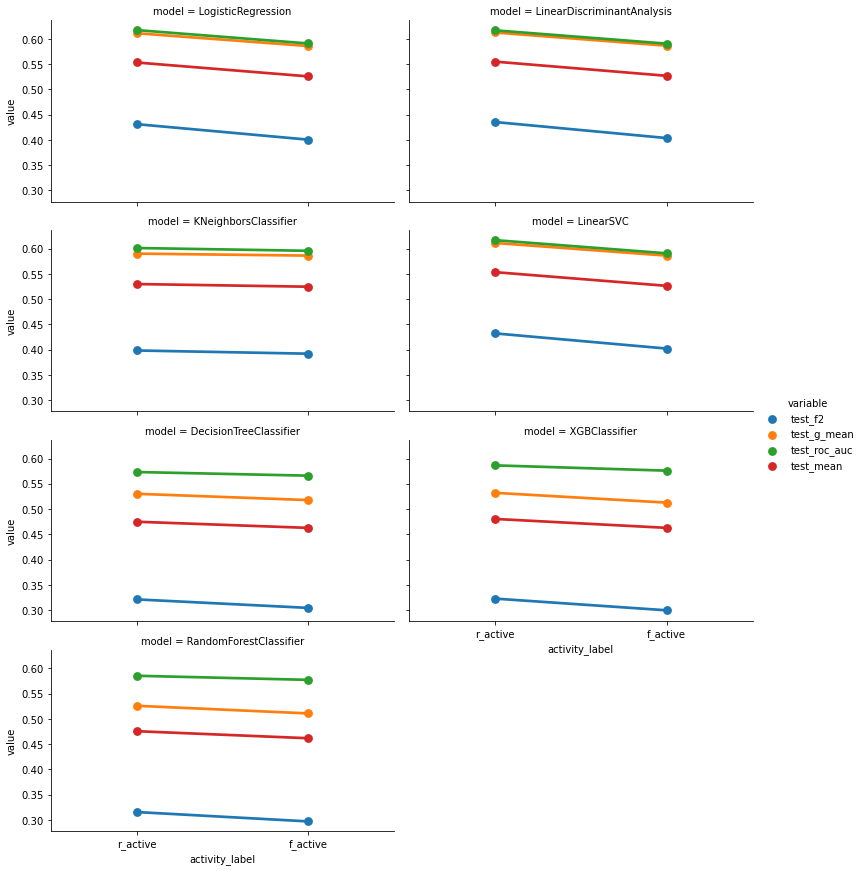

In [22]:
melt = pd.melt(scores_data, id_vars=['activity_label','model',*train_set], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=melt, x='activity_label', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)

In [23]:
df = scores_data.groupby(['model','activity_label']).describe()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

test_accuracy                      \
                                                  count      mean       std   
model                      activity_label                                     
DecisionTreeClassifier     f_active               884.0  0.724954  0.030875   
                           r_active               884.0  0.722564  0.032654   
KNeighborsClassifier       f_active               884.0  0.660298  0.043001   
                           r_active               884.0  0.675419  0.042747   
LinearDiscriminantAnalysis f_active               884.0  0.618657  0.052357   
                           r_active               884.0  0.648487  0.052958   
LinearSVC                  f_active               884.0  0.623167  0.055125   
                           r_active               884.0  0.655491  0.056886   
LogisticRegression         f_active               884.0  0.627649  0.055924   
                           r_active               884.0  0.659774  0.058763   
RandomForestClassifier     f_active               884.0  0.764428  0.037093   
                           r_active               884.0  0.762580  0.037695   
XGBClassifier              f_active               884.0  0.757314  0.040080   
                           r_active               884.0  0.755567  0.040638   

                                                                         \
                                                min       25%       50%   
model                      activity_label                                 
DecisionTreeClassifier     f_active        0.569400  0.710453  0.729599   
                           r_active        0.563108  0.706225  0.729579   
KNeighborsClassifier       f_active        0.551404  0.629898  0.664892   
                           r_active        0.568382  0.645835  0.681338   
LinearDiscriminantAnalysis f_active        0.468729  0.576847  0.625648   
                           r_active        0.476143  0.609793  0.664884   
LinearSVC                  f_active        0.469791  0.578712  0.629909   
                           r_active        0.476143  0.610567  0.675498   
LogisticRegression         f_active        0.470849  0.580040  0.638373   
                           r_active        0.489974  0.610845  0.680784   
RandomForestClassifier     f_active        0.549321  0.747309  0.769867   
                           r_active        0.567368  0.745501  0.769872   
XGBClassifier              f_active        0.569400  0.735668  0.766687   
                           r_active        0.567368  0.738058  0.765646   

                                                              test_precision  \
                                                75%       max          count   
model                      activity_label                                      
DecisionTreeClassifier     f_active        0.746536  0.796408          884.0   
                           r_active        0.743390  0.790048          884.0   
KNeighborsClassifier       f_active        0.689294  0.775109          884.0   
                           r_active        0.708381  0.772018          884.0   
LinearDiscriminantAnalysis f_active        0.655320  0.713618          884.0   
                           r_active        0.688222  0.730664          884.0   
LinearSVC                  f_active        0.661689  0.721043          884.0   
                           r_active        0.699880  0.734897          884.0   
LogisticRegression         f_active        0.665922  0.729518          884.0   
                           r_active        0.707301  0.744397          884.0   
RandomForestClassifier     f_active        0.788961  0.829249          884.0   
                           r_active        0.787121  0.829262          884.0   
XGBClassifier              f_active        0.786049  0.828214          884.0   
                           r_active        0.783682  0.822903          884.0   

                                                             

<a id='docking'></a>
### Docking scores and performance increment

Text(0.5, 1.05, 'test_roc_auc')

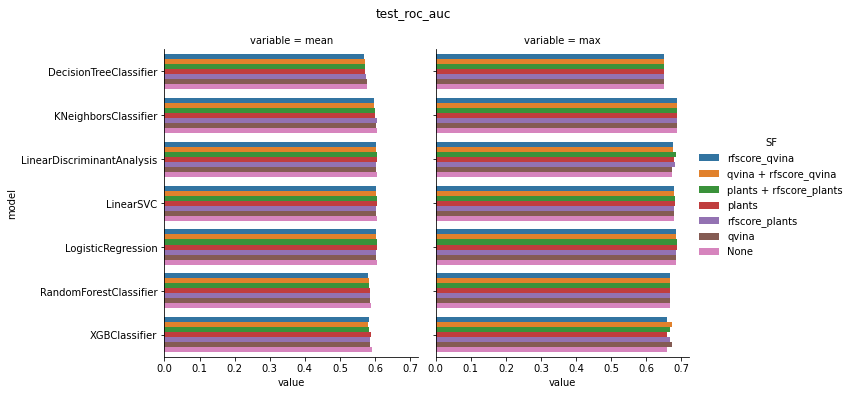

In [24]:
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

compare = pd.melt(df, id_vars=['model','SF'], value_vars=['mean','max'])
sns.catplot(kind='bar', data=compare, y='model', x='value', col='variable', hue='SF')
plt.suptitle('test_roc_auc', y=1.05)

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.

<a id='top_descriptors'></a>
### Top descriptors

Text(0.5, 0.98, 'Most frequent descriptors in the top 1% scores')

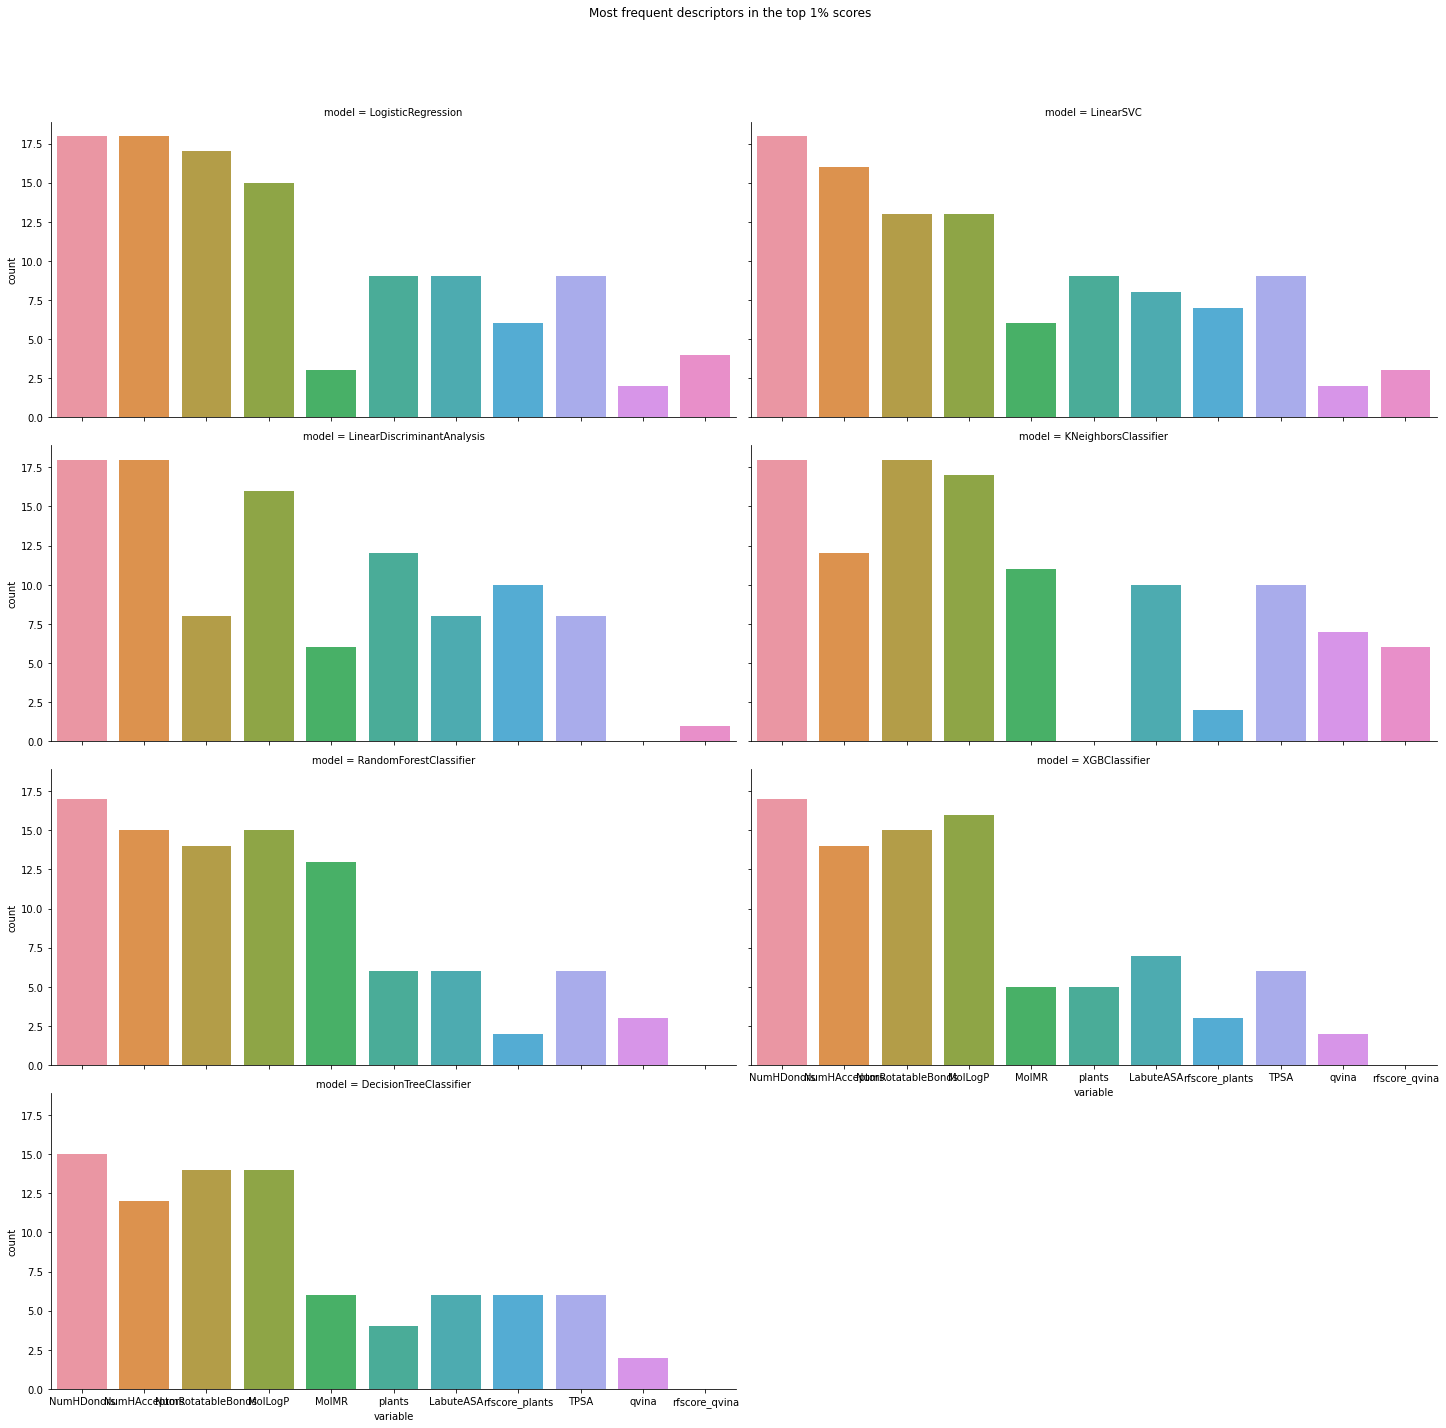

In [25]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=[*test_metrics,'activity_label','model','test_mean'], value_vars=train_set, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

g = sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', col_wrap=2, aspect=2)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Most frequent descriptors in the top 1% scores')

The frequency count shows the most recurring descriptors in each model's top 1% results are: 

In [26]:
for key, value in best_subset.items():
    print(key, value)
    print()

LogisticRegression ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'LabuteASA', 'MolLogP', 'plants']

LinearDiscriminantAnalysis ['NumHAcceptors', 'NumHDonors', 'TPSA', 'LabuteASA', 'MolLogP', 'plants', 'rfscore_plants']

KNeighborsClassifier ['MolMR', 'NumRotatableBonds', 'NumHDonors', 'LabuteASA', 'MolLogP']

LinearSVC ['MolMR', 'NumHAcceptors', 'NumHDonors', 'MolLogP']

DecisionTreeClassifier ['NumRotatableBonds', 'NumHDonors']

XGBClassifier ['NumRotatableBonds', 'NumHDonors']

RandomForestClassifier ['NumRotatableBonds', 'NumHDonors']



In [27]:
from sklearn.model_selection import StratifiedKFold

# Confusion matrix

from sklearn.metrics import confusion_matrix, log_loss

model_name = 'XGBClassifier'
subset = best_subset[model_name]

y = new_data[activity_label]
X = new_data[subset]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

scaler = StandardScaler()
pipe = make_pipeline(SMOTE(random_state=42), scaler, XGBClassifier(objective='reg:logistic', random_state=13))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y): 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    break
    
pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

#     Predicted   inactive |  active
# Actual 
# inactive      |    TN    |    FP    | 
# active        |    FN    |    TP    | 

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
matrix = pd.DataFrame(conf_matrix)

print(f'RMSE: {np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test)):.4f}')
print(f'log_loss: {log_loss(y_test, y_proba):.4f}')
matrix

RMSE: 0.4631
log_loss: 0.6176


,0,1
0,0.604938,0.395062
1,0.296296,0.703704


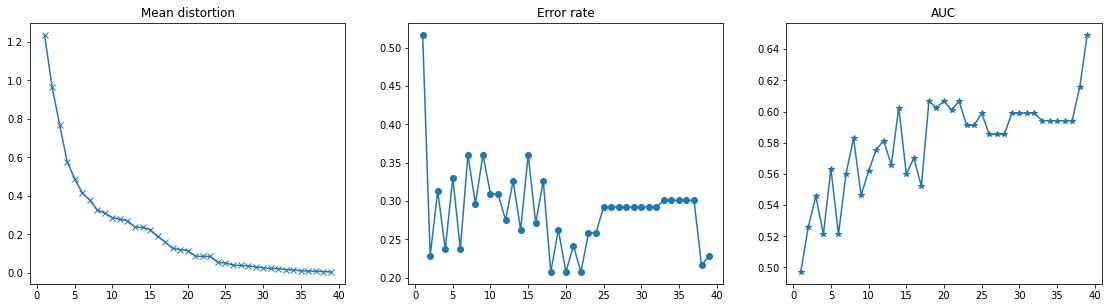

In [28]:
# Finding the optimal K value for KNeighborsClassifier

from sklearn.cluster import KMeans
from scipy.spatial import distance

model_name = 'XGBClassifier'
subset = best_subset[model_name]

y = new_data[activity_label]
X = new_data[subset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

K = range(1, 40) 
mean_distortions = []
error_rate = []
auc_list = []
fig, ax = plt.subplots(ncols=3, figsize=(6.4*3, 4.8))

for i in K:
    kmeans = KMeans(n_clusters=i)
    kmeans = kmeans.fit(X_train)
    mean_distortions.append(sum(np.min(distance.cdist(X_train, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0])
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    auc_list.append(roc_auc_score(y_test, pred_i))

ax[0].plot(K, mean_distortions, 'x-')
ax[1].plot(K, error_rate, 'o-', label='')
ax[2].plot(K, auc_list, '*-')
ax[0].set_title('Mean distortion')
ax[1].set_title('Error rate')
ax[2].set_title('AUC')
plt.show()

In [29]:
# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr, tpr,_ = roc_curve(y_train, train_data[model_name])
    plt.plot(fpr, tpr, label=f'{model_name}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Some legends
plt.legend(title='Scoring function', loc='lower right')
plt.title('Receiver Operating Characteristic')
plt.savefig('sf_roc_curve.png', dpi=216)

ValueError: Found input variables with inconsistent numbers of samples: [1204, 629]

In [ ]:
# Completar overview
